# Analyze failed balance/sales distributions

In [8]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title plot_balance_distributions

# Visualize balance distribution by classes (0, 1) for first/second product with quantiles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_balance_distributions(df_model):
    # Check if 'label' exists in df_model
    if 'label' in df_model.columns:
        # Create a figure with 2 subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot balance_first distribution by class with quantiles, without outliers
        sns.boxplot(x='label', y='balance_first', data=df_model, ax=axes[0], 
                    showfliers=False, whis=[5, 90], showmeans=True, 
                    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
        
        # # Add quantile lines for balance_first
        # for label in df_model['label'].unique():
        #     quantiles = df_model[df_model['label'] == label]['balance_first'].quantile([0.25, 0.5, 0.75]).values
        #     for i, q in enumerate(quantiles):
        #         axes[0].axhline(y=q, color='r', linestyle='--', alpha=0.3)
        
        axes[0].set_title('Balance Distribution (First Product) by Class')
        axes[0].set_xlabel('Class (0: Not Similar, 1: Similar)')
        axes[0].set_ylabel('Balance')
        
        # Plot balance_second distribution by class with quantiles, without outliers
        sns.boxplot(x='label', y='balance_second', data=df_model, ax=axes[1], 
                    showfliers=False, whis=[5, 90], showmeans=True,
                    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
        
        # # Add quantile lines for balance_second
        # for label in df_model['label'].unique():
        #     quantiles = df_model[df_model['label'] == label]['balance_second'].quantile([0.25, 0.5, 0.75]).values
        #     for i, q in enumerate(quantiles):
        #         axes[1].axhline(y=q, color='r', linestyle='--', alpha=0.3)
        
        axes[1].set_title('Balance Distribution (Second Product) by Class')
        axes[1].set_xlabel('Class (0: Not Similar, 1: Similar)')
        axes[1].set_ylabel('Balance')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed quantile statistics
        print("Quantile statistics for balance_first by class:")
        quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        display(df_model.groupby('label')['balance_first'].quantile(quantiles).unstack())
        
        print("\nQuantile statistics for balance_second by class:")
        display(df_model.groupby('label')['balance_second'].quantile(quantiles).unstack())
    else:
        print("Label column not found in the dataset")

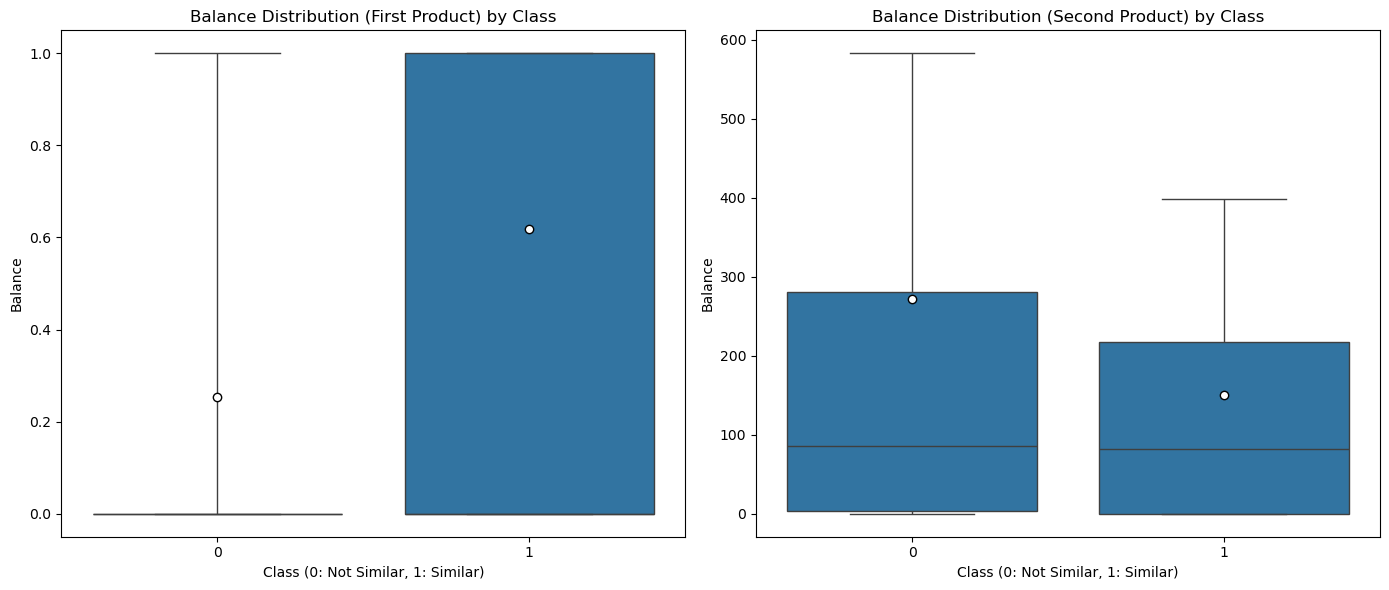

Quantile statistics for balance_first by class:


,0.10,0.25,0.50,0.75,0.90
label,,,,,
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,1.0



Quantile statistics for balance_second by class:


,0.10,0.25,0.50,0.75,0.90
label,,,,,
0,0.0,3.0,86.0,281.00,583.0
1,0.0,0.0,81.5,217.25,443.0


In [ ]:
plot_balance_distributions(
    # df_model,
    df_model_domain,
)

In [9]:
import pandas as pd

# Load the Excel file
file_path = 'data/tables_OZ_geo_5500/source/конкуренты_АП.xlsx'
df_results = pd.read_excel(file_path)

# Load the full dataset
df_all_path = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded.csv'
df_all = pd.read_csv(df_all_path)

In [10]:

# Prepare lists to hold the SKUs failing for each condition.
balance_failed_skus = []
sales_failed_skus = []

# Iterate through all rows of the dataframe
balance_failed_skus_with_coords = []
sales_failed_skus_with_coords = []

for idx, row in df_results.iterrows():
    # Loop over candidate positions from 1 to 5 (adjust if you have more)
    for i in range(1, 6):
        reason_col = f'Столбец {i}'
        sku_col = f'Top-{i}_SKU'
        
        # Retrieve the reason and nonfailedize to lower-case for checking
        reason = str(row[reason_col]) if pd.notna(row[reason_col]) else ''
        sku = row[sku_col]
        
        # Convert to Excel-like coordinates (e.g., C16)
        # Column letters for Столбец 1-5 would be mapped to appropriate Excel columns
        col_letter = chr(ord('A') + (i + 1))  # +1 offset since Столбец starts at column B or C typically
        excel_coord = f"{col_letter}{idx + 2}"  # +2 for header row and 0-indexing
        
        # Check if the reason contains "balance"
        if "остатки" in reason.lower():
            balance_failed_skus.append(sku)
            balance_failed_skus_with_coords.append((sku, excel_coord))
        
        # Check if the reason contains "sales"
        if "продажи" in reason.lower():
            sales_failed_skus.append(sku)
            sales_failed_skus_with_coords.append((sku, excel_coord))

# Create unique lists of SKUs (without coordinates)
balance_failed_skus = list(set(balance_failed_skus))
sales_failed_skus = list(set(sales_failed_skus))

# Keep the coordinate information in separate lists
print(f"Total balance failures with coordinates: {len(balance_failed_skus_with_coords)}")
print(f"Total sales failures with coordinates: {len(sales_failed_skus_with_coords)}")

Total balance failures with coordinates: 41
Total sales failures with coordinates: 75


In [11]:
pd.reset_option('display.max_colwidth')

# Get sales data for both non-failed and failed SKUs
# Create lists for failed and non-failed balance SKUs
nonfailed_balance_skus = [sku for sku in balance_failed_skus if sku not in sales_failed_skus]
failed_balance_skus = [sku for sku in balance_failed_skus if sku in sales_failed_skus]

nonfailed_sales = df_all[
    ~df_all['sku_second'].isin(sales_failed_skus)
    & df_all['sku_second'].isin(balance_failed_skus)
].drop_duplicates(subset=['sku_second']).set_index('sku_second')['sales_second']

failed_sales = df_all[
    df_all['sku_second'].isin(sales_failed_skus)
    & df_all['sku_second'].isin(balance_failed_skus)
].drop_duplicates(subset=['sku_second']).set_index('sku_second')['sales_second']


# Calculate quantiles to truncate the distributions
q_upper = 0.99  # Truncate at 95th percentile
q_lower = 1-q_upper  # Truncate at 5th percentile
nonfailed_upper_limit = nonfailed_sales.quantile(q_upper)
nonfailed_lower_limit = nonfailed_sales.quantile(q_lower)
failed_upper_limit = failed_sales.quantile(q_upper)
failed_lower_limit = failed_sales.quantile(q_lower)

# Truncate the data for visualization
nonfailed_sales_truncated = nonfailed_sales[(nonfailed_sales <= nonfailed_upper_limit) & 
                                           (nonfailed_sales >= nonfailed_lower_limit)]
failed_sales_truncated = failed_sales[(failed_sales <= failed_upper_limit) & 
                                     (failed_sales >= failed_lower_limit)]

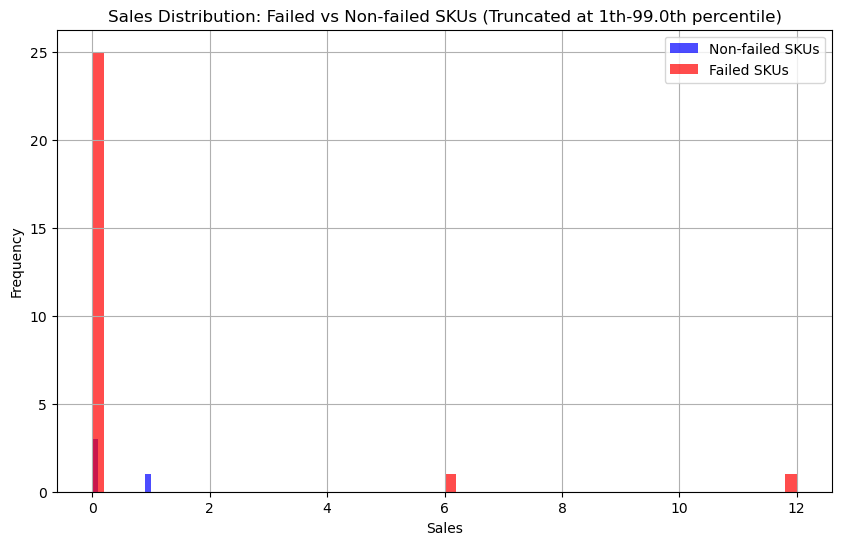

In [12]:
# Create a figure for plotting truncated distributions
plt.figure(figsize=(10, 6))
nonfailed_sales_truncated.hist(bins=10, alpha=0.7, label='Non-failed SKUs', color='blue')
failed_sales_truncated.hist(bins=60, alpha=0.7, label='Failed SKUs', color='red')
plt.legend()
plt.title(f'Sales Distribution: Failed vs Non-failed SKUs (Truncated at {round(q_lower*100)}th-{q_upper*100}th percentile)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Display statistics for both SALES distributions
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# percentiles = np.linspace(0, 0.2, 10)

# Create a combined table of statistics for both distributions
nonfailed_stats = nonfailed_sales.describe(percentiles=percentiles)
failed_stats = failed_sales.describe(percentiles=percentiles)

# Rename the series for clarity in the combined table
nonfailed_stats.name = "Non-failed SKUs"
failed_stats.name = "Failed SKUs"

# Concatenate the statistics side by side
combined_stats = pd.concat([nonfailed_stats, failed_stats], axis=1)

# Display the combined table
display(combined_stats)

,Non-failed SKUs,Failed SKUs
count,5.000000,28.000000
mean,3.200000,1.392857
std,6.610598,4.581277
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
90%,9.400000,1.800000
95%,12.200000,9.900000
99%,14.440000,18.570000


In [14]:
# Print URLs of failed SKUs in descending order of sales
print("\nFailed SKUs URLs in descending order of sales:")

# Filter failed SKUs and select relevant columns
failed_skus_with_urls = df_all[
    df_all['sku_second'].isin(sales_failed_skus)
    & df_all['sku_second'].isin(balance_failed_skus)
][['sku_second', 'url_second', 'sales_second']]

# Remove duplicates
failed_skus_with_urls = failed_skus_with_urls.drop_duplicates(subset=['sku_second'])

# Sort by sales in descending order
failed_skus_sorted = failed_skus_with_urls.sort_values(
    by='sales_second', 
    ascending=False
)

# Print header
print("sku_second      url_second                                           sales_second")

# Print each row
for _, row in failed_skus_sorted.iterrows():
    print(f"{row['sku_second']: <15} {row['url_second']: <50} {row['sales_second']}")


Failed SKUs URLs in descending order of sales:
sku_second      url_second                                           sales_second
178734811       https://www.ozon.ru/context/detail/id/178734811/   21
1671095638      https://www.ozon.ru/context/detail/id/1671095638/  12
1743558896      https://www.ozon.ru/context/detail/id/1743558896/  6
1436684652      https://www.ozon.ru/context/detail/id/1436684652/  0
1581328082      https://www.ozon.ru/context/detail/id/1581328082/  0
679265207       https://www.ozon.ru/context/detail/id/679265207/   0
1876314221      https://www.ozon.ru/context/detail/id/1876314221/  0
1663681734      https://www.ozon.ru/context/detail/id/1663681734/  0
1564147791      https://www.ozon.ru/context/detail/id/1564147791/  0
1665388300      https://www.ozon.ru/context/detail/id/1665388300/  0
1581230356      https://www.ozon.ru/context/detail/id/1581230356/  0
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  0
625539152       https://www.ozon.ru/cont

In [15]:
# Print URLs of non-failed SKUs in ascending order of sales
print("\nNon-failed SKUs URLs in ascending order of sales:")

# Filter non-failed SKUs and select relevant columns
non_failed_skus_with_urls = df_all[
    ~df_all['sku_second'].isin(sales_failed_skus)
    & df_all['sku_second'].isin(balance_failed_skus)
][['sku_second', 'url_second', 'sales_second']]

# Remove duplicates
non_failed_skus_with_urls = non_failed_skus_with_urls.drop_duplicates(subset=['sku_second'])

# Sort by sales in ascending order
non_failed_skus_sorted = non_failed_skus_with_urls.sort_values(
    by='sales_second', 
    ascending=True
)

# Print header
print("sku_second      url_second                                           sales_second")

# Print each row
for _, row in non_failed_skus_sorted.iterrows():
    print(f"{row['sku_second']: <15} {row['url_second']: <50} {row['sales_second']}")


Non-failed SKUs URLs in ascending order of sales:
sku_second      url_second                                           sales_second
1387125983      https://www.ozon.ru/context/detail/id/1387125983/  0
1247589234      https://www.ozon.ru/context/detail/id/1247589234/  0
1005611591      https://www.ozon.ru/context/detail/id/1005611591/  0
1857130100      https://www.ozon.ru/context/detail/id/1857130100/  1
851623566       https://www.ozon.ru/context/detail/id/851623566/   15


In [16]:
pd.reset_option('display.max_colwidth')

# Get balance data for both failed and non-failed SKUs
nonfailed_balance_skus = df_all[
    ~df_all['sku_second'].isin(balance_failed_skus)
    & df_all['sku_second'].isin(sales_failed_skus)
].index

nonfailed_balance = df_all.loc[nonfailed_balance_skus].balance_second

failed_balance_skus = df_all[
    df_all['sku_second'].isin(balance_failed_skus)
    & df_all['sku_second'].isin(sales_failed_skus)
].index

failed_balance = df_all.loc[failed_balance_skus].balance_second

# Calculate quantiles to truncate the distributions
q_upper = 0.99  # Truncate at 95th percentile
nonfailed_upper_limit = nonfailed_balance.quantile(q_upper)
failed_upper_limit = failed_balance.quantile(q_upper)

# Truncate the data for visualization
nonfailed_balance_truncated = nonfailed_balance[nonfailed_balance <= nonfailed_upper_limit]
failed_balance_truncated = failed_balance[failed_balance <= failed_upper_limit]

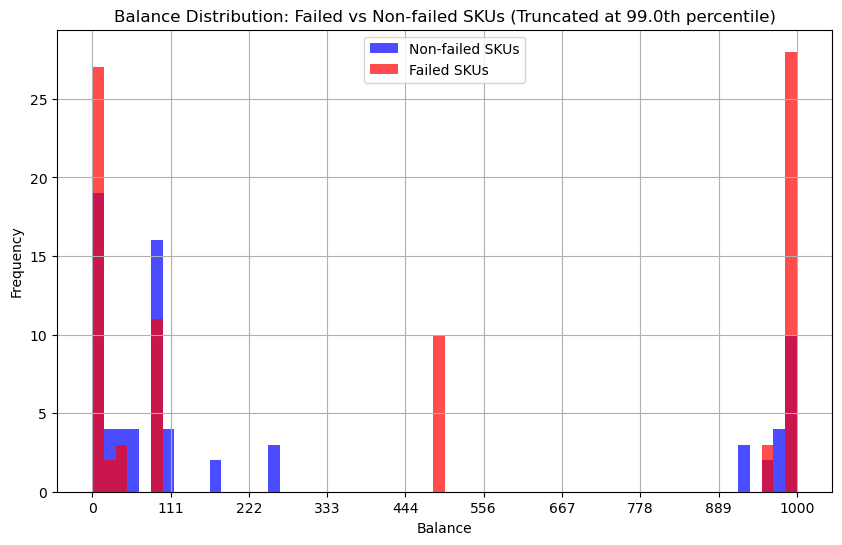

In [17]:
# Create a figure for plotting truncated distributions
plt.figure(figsize=(10, 6))
nonfailed_balance_truncated.hist(bins=60, alpha=0.7, label='Non-failed SKUs', color='blue')
failed_balance_truncated.hist(bins=60, alpha=0.7, label='Failed SKUs', color='red')

plt.legend()
plt.title(f'Balance Distribution: Failed vs Non-failed SKUs (Truncated at {q_upper*100}th percentile)')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Add more x-axis labels
max_balance = max(nonfailed_balance_truncated.max(), failed_balance_truncated.max())
plt.xticks(np.linspace(0, max_balance, 10))

plt.show()

In [18]:
# Display statistics for both distributions
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# percentiles = np.linspace(0, 0.2, 10)

# Create a combined table of statistics for both distributions
nonfailed_stats = nonfailed_balance.describe(percentiles=percentiles)
failed_stats = failed_balance.describe(percentiles=percentiles)

# Rename the series for clarity in the combined table
nonfailed_stats.name = "Non-failed SKUs"
failed_stats.name = "Failed SKUs"

# Concatenate the statistics side by side
combined_stats = pd.concat([nonfailed_stats, failed_stats], axis=1)

# Display the combined table
display(combined_stats)

,Non-failed SKUs,Failed SKUs
count,75.000000,84.000000
mean,296.013333,441.690476
std,402.183987,450.686624
min,0.000000,0.000000
25%,17.500000,5.000000
50%,97.000000,97.000000
75%,584.000000,997.000000
90%,998.000000,999.000000
95%,998.000000,999.000000
99%,1000.000000,1000.000000


In [19]:
# Print URLs of failed SKUs in descending order of balance
print("\nFailed SKUs URLs in descending order of balance:")
failed_skus_with_urls = df_all.loc[failed_balance_skus][['sku_second', 'url_second', 'balance_second']]
failed_skus_sorted = failed_skus_with_urls.sort_values(by='balance_second', ascending=False)
print("sku_second      url_second    balance_second") 
for idx, row in failed_skus_sorted.iterrows():
    print(f"{row['sku_second']: <15} {row['url_second']: <50} {row['balance_second']}")


Failed SKUs URLs in descending order of balance:
sku_second      url_second    balance_second
1436684652      https://www.ozon.ru/context/detail/id/1436684652/  1000
1436684652      https://www.ozon.ru/context/detail/id/1436684652/  1000
1436684652      https://www.ozon.ru/context/detail/id/1436684652/  1000
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  999
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  999
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  999
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  999
679265207       https://www.ozon.ru/context/detail/id/679265207/   999
1436513974      https://www.ozon.ru/context/detail/id/1436513974/  999
679265207       https://www.ozon.ru/context/detail/id/679265207/   999
679265207       https://www.ozon.ru/context/detail/id/679265207/   999
679265207       https://www.ozon.ru/context/detail/id/679265207/   999
536712251       https://www.ozon.ru/context/detail

In [20]:
# Print URLs of non-failed SKUs in ascending order of balance
print("\nNon-failed SKUs URLs in ascending order of balance:")
non_failed_skus_with_urls = df_all.loc[nonfailed_balance_skus][['sku_second', 'url_second', 'balance_second']]
non_failed_skus_sorted = non_failed_skus_with_urls.sort_values(by='balance_second', ascending=True)
print("sku_second      url_second                                           balance_second")
for idx, row in non_failed_skus_sorted.iterrows():
    print(f"{row['sku_second']: <15} {row['url_second']: <50} {row['balance_second']}")


Non-failed SKUs URLs in ascending order of balance:
sku_second      url_second                                           balance_second
471852351       https://www.ozon.ru/context/detail/id/471852351/   0
484538633       https://www.ozon.ru/context/detail/id/484538633/   1
484538633       https://www.ozon.ru/context/detail/id/484538633/   1
484538633       https://www.ozon.ru/context/detail/id/484538633/   1
484538633       https://www.ozon.ru/context/detail/id/484538633/   1
484538633       https://www.ozon.ru/context/detail/id/484538633/   1
808560063       https://www.ozon.ru/context/detail/id/808560063/   5
808560063       https://www.ozon.ru/context/detail/id/808560063/   5
808560063       https://www.ozon.ru/context/detail/id/808560063/   5
601310061       https://www.ozon.ru/context/detail/id/601310061/   10
601310061       https://www.ozon.ru/context/detail/id/601310061/   10
601310061       https://www.ozon.ru/context/detail/id/601310061/   10
601310061       https://www.ozon

Verdict: 
- balance_second >= 100
- sales_second >= 1
- rating_second >= 4.3